In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [3]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    # TARGET
    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna()   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [4]:
df = make_features(df)

In [5]:
def add_time_features(df_enriched: pd.DataFrame, period: int = 600):

    theta = 2 * np.pi * df_enriched['seconds_in_bucket'] / period
    df_enriched['sec_sin'] = np.sin(theta)
    df_enriched['sec_cos'] = np.cos(theta)

    return df_enriched.drop(columns=["seconds_in_bucket"])

df = add_time_features(df)

In [6]:
for c in ['bid_size1','ask_size1','bid_size2','ask_size2']:
    df[c + '_log'] = np.log1p(df[c])
    df.drop(columns=c, inplace=True)

In [7]:
feature_cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
       'stock_id', 'mid_price', 'spread', 'imbalance', 'book_pressure',
       'microprice', 'normalized_spread', 'OBI_L2', 'LOB_entropy',
       'LOB_entropy_normalized', 'log_return', 'realized_volatility', 'bipower_var', 'wap', 'log_wap_return', 'imbalance_lag1',
       'imbalance_lag2', 'book_pressure_lag1', 'book_pressure_lag2',
       'log_return_lag1', 'log_return_lag2', 'rolling_vol_30',
       'rolling_imbalance_mean_30', 'sec_sin', 'sec_cos', 'bid_size1_log',
       'ask_size1_log', 'bid_size2_log', 'ask_size2_log']
target_col = "rv_future"

In [8]:
df['rv_future_log'] = np.log1p(df['rv_future'])
feature_cols_mod = [c for c in feature_cols if c!='rv_future'] 
target_col_mod     = 'rv_future_log'

In [9]:
unique_sessions = df["time_id"].sort_values().unique()
split_idx       = int(len(unique_sessions) * 0.8)          
train_sessions  = unique_sessions[:split_idx]
test_sessions   = unique_sessions[split_idx:]

In [10]:
train_df = df[df["time_id"].isin(train_sessions)].copy()
test_df  = df[df["time_id"].isin(test_sessions)].copy()

In [13]:
x_scaler = MinMaxScaler().fit(train_df[feature_cols_mod])
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(train_df[[target_col_mod]])

train_df[feature_cols_mod] = x_scaler.transform(train_df[feature_cols_mod])
test_df[feature_cols_mod]  = x_scaler.transform(test_df[feature_cols_mod])
train_df[target_col_mod]   = y_scaler.transform(train_df[[target_col_mod]])
test_df[target_col_mod]    = y_scaler.transform(test_df[[target_col_mod]])

In [14]:
SEQ_LEN = 30   

def build_sequences(df_part: pd.DataFrame, feature_cols, target_col, seq_len):
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X), np.asarray(y)

In [15]:
val_split_idx = int(len(train_sessions) * 0.9)
val_sessions  = train_sessions[val_split_idx:]
train_sessions= train_sessions[:val_split_idx]

val_df = train_df[train_df["time_id"].isin(val_sessions)]
train_df = train_df[train_df["time_id"].isin(train_sessions)]

X_train, y_train = build_sequences(train_df, feature_cols_mod, 'rv_future_log', SEQ_LEN)
X_val,   y_val   = build_sequences(val_df,   feature_cols_mod, 'rv_future_log', SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols_mod, 'rv_future_log', SEQ_LEN)

In [17]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val   = X_val.reshape(X_val.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

In [19]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      n_jobs=-1, random_state=42)

In [36]:
val_pred  = rf.predict(X_val)
val_rmse  = root_mean_squared_error(y_val, val_pred)
print(f"Validation RMSE: {val_rmse:.6f}")

Validation RMSE: 0.030797


In [21]:
pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
print(f"Out-of-sample RMSE = {rmse:.6f}")

Out-of-sample RMSE = 0.033617


In [ ]:
pred_scaled = pred.flatten()
actual_scaled = y_test.flatten()
predictions = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actuals     = y_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

In [34]:
r2 = r2_score(actuals, predictions)
print(f"R² score (σ prediction) = {r2:.6f}")

R² score (σ prediction) = 0.438629


In [35]:
def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(actuals, predictions)
print("QLIKE:", ql)

QLIKE: 0.13458482790452278


In [28]:
flattened_feature_names = [
    f"{feat}_t{-i}" for i in reversed(range(30)) for feat in feature_cols
]
top_n = 30
imp = pd.Series(rf.feature_importances_, index=flattened_feature_names).sort_values(ascending=False)[:top_n]

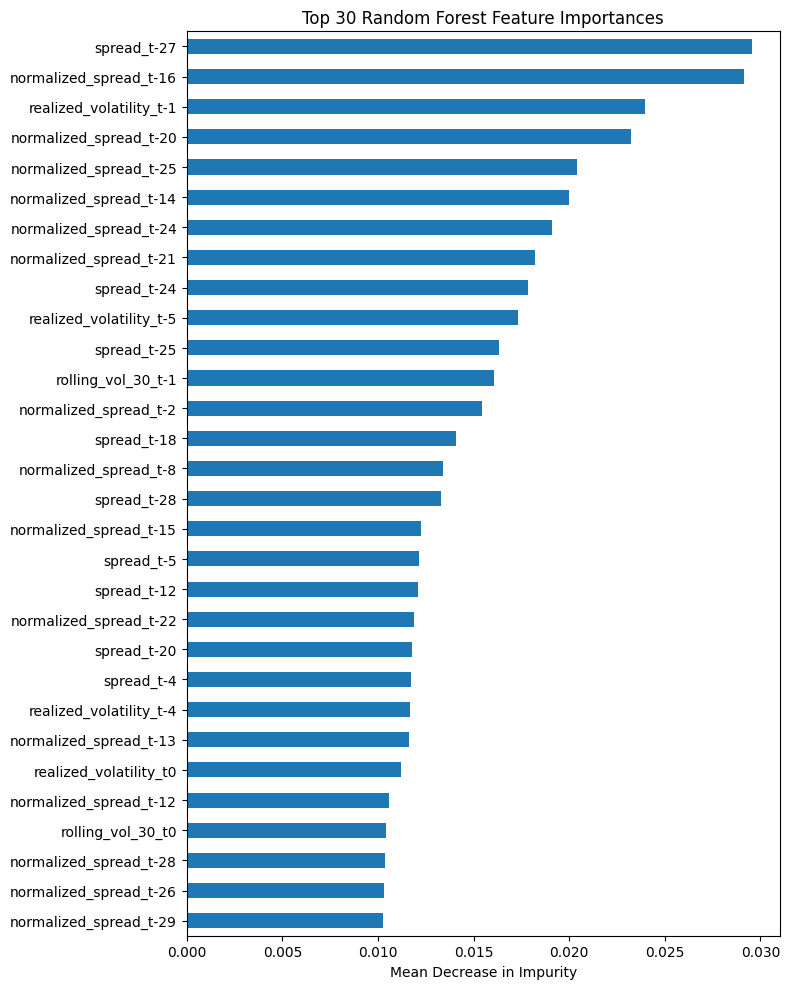

In [29]:
plt.figure(figsize=(8, 10))
imp.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 30 Random Forest Feature Importances")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

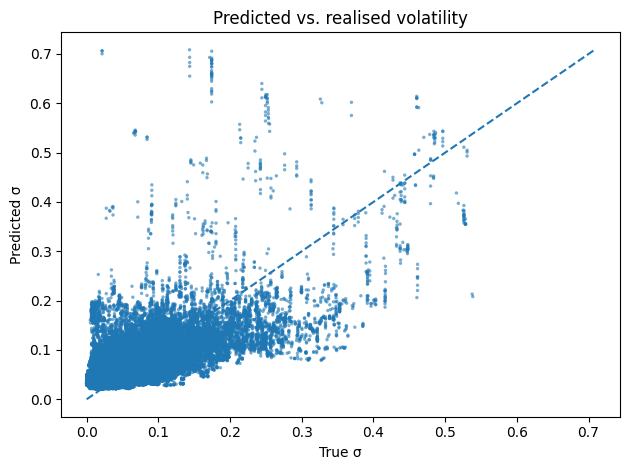

In [30]:
plt.figure()
plt.scatter(y_test, pred, s=6, alpha=0.6, edgecolor="none")
max_val = max(np.max(y_test), np.max(pred))
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.title("Predicted vs. realised volatility")
plt.xlabel("True σ")
plt.ylabel("Predicted σ")
plt.tight_layout()
plt.show()

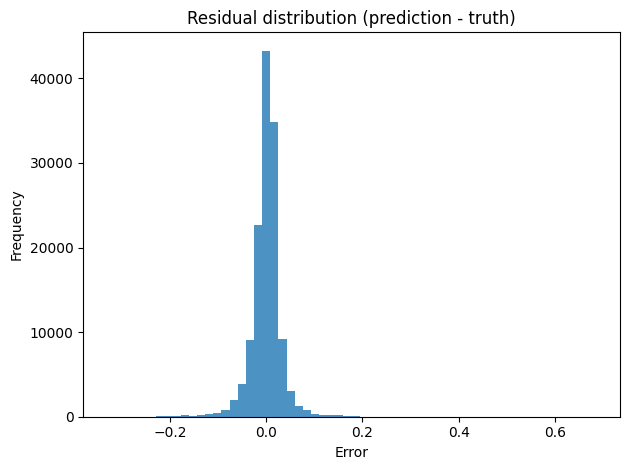

In [31]:
residuals = pred - y_test
plt.figure()
plt.hist(residuals, bins=60, alpha=0.8)
plt.title("Residual distribution (prediction - truth)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()